In [516]:
import numpy as np
import pandas as pd



In [517]:

data = pd.read_csv('TATAMOTORS.NS.csv')
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values('Date')
price = data['Close']
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-24,427.000000,429.950012,424.250000,425.500000,425.500000,5108182
1,2017-11-27,423.000000,424.750000,417.799988,421.399994,421.399994,7946028
2,2017-11-28,419.799988,422.250000,414.500000,415.950012,415.950012,6217480
3,2017-11-29,415.899994,419.450012,412.049988,413.950012,413.950012,4327453
4,2017-11-30,410.399994,412.250000,402.250000,404.149994,404.149994,25646262


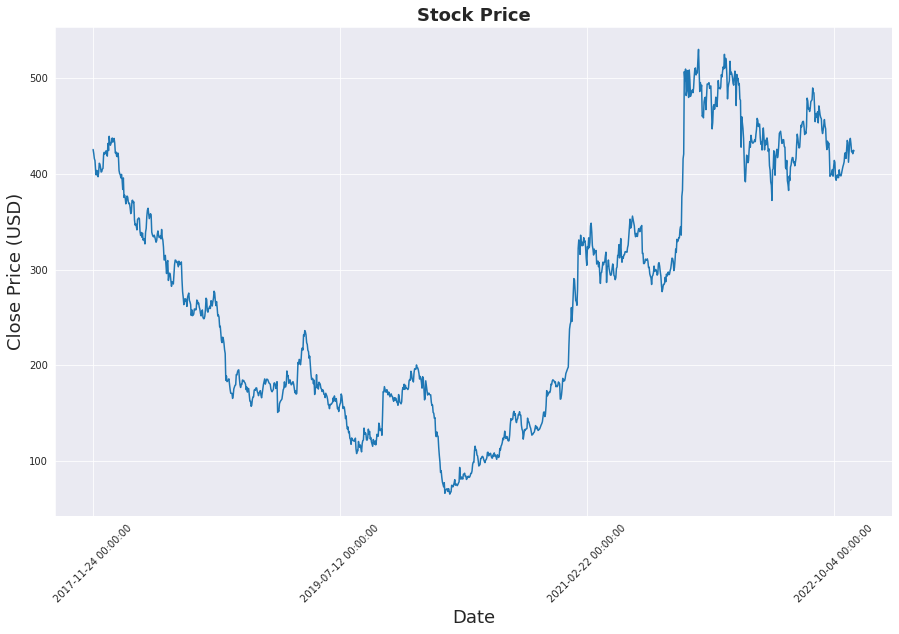

In [518]:
import matplotlib.pyplot as plt
import seaborn as sns


days_number = 400
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data['Close'])
plt.xticks(range(0,data.shape[0],days_number),data['Date'].loc[::days_number],rotation=45)
plt.title("Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [519]:
#Normalization of data
price = data[['Close']]
price.info()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234 entries, 0 to 1233
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1234 non-null   float64
dtypes: float64(1)
memory usage: 19.3 KB
x_train.shape =  (963, 29, 1)
y_train.shape =  (963, 1)
x_test.shape =  (241, 29, 1)
y_test.shape =  (241, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [520]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [521]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [522]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [523]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3823687732219696
Epoch  1 MSE:  0.2577327787876129
Epoch  2 MSE:  0.17972518503665924
Epoch  3 MSE:  0.20540684461593628
Epoch  4 MSE:  0.16479796171188354
Epoch  5 MSE:  0.14237068593502045
Epoch  6 MSE:  0.13714900612831116
Epoch  7 MSE:  0.12842801213264465
Epoch  8 MSE:  0.10641544312238693
Epoch  9 MSE:  0.07204779237508774
Epoch  10 MSE:  0.061231765896081924
Epoch  11 MSE:  0.057034723460674286
Epoch  12 MSE:  0.023602252826094627
Epoch  13 MSE:  0.0282956101000309
Epoch  14 MSE:  0.035517048090696335
Epoch  15 MSE:  0.02455473132431507
Epoch  16 MSE:  0.025865662842988968
Epoch  17 MSE:  0.026780828833580017
Epoch  18 MSE:  0.015817228704690933
Epoch  19 MSE:  0.01029318105429411
Epoch  20 MSE:  0.012744084000587463
Epoch  21 MSE:  0.01568606309592724
Epoch  22 MSE:  0.01524310652166605
Epoch  23 MSE:  0.012158513069152832
Epoch  24 MSE:  0.009093410335481167
Epoch  25 MSE:  0.008227676153182983
Epoch  26 MSE:  0.009688673540949821
Epoch  27 MSE:  0.01121741533

In [524]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

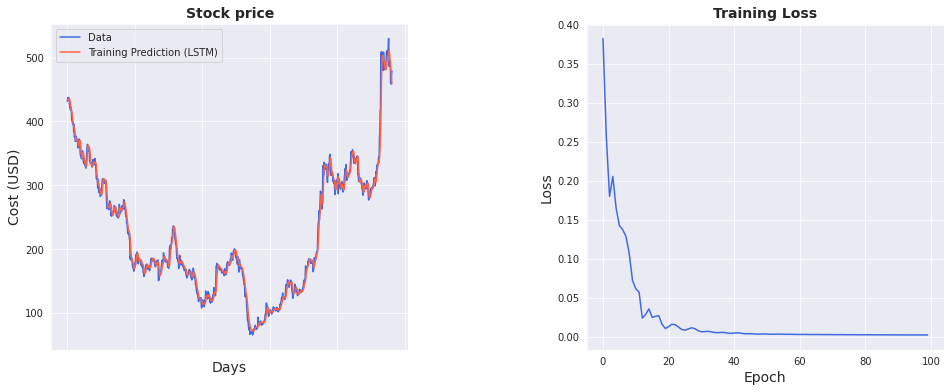

In [525]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('',size = 14)



plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('loss_prediction.jpg')
plt.show()

In [526]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 10.41 RMSE
Test Score: 12.99 RMSE


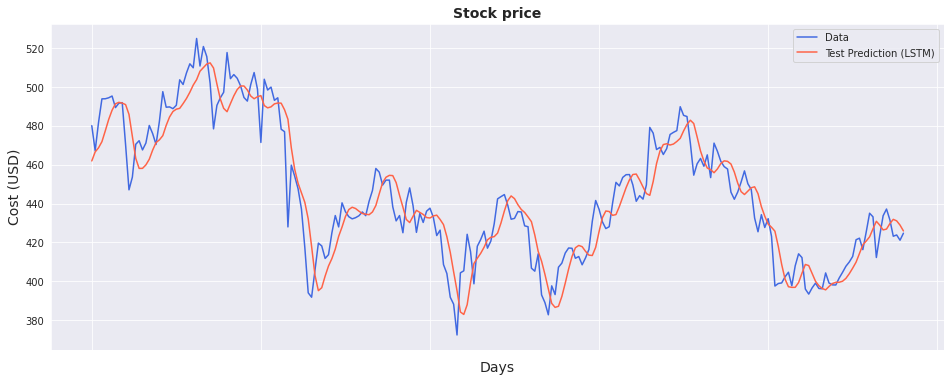

In [527]:
original = pd.DataFrame(y_test)
predict = pd.DataFrame(y_test_pred)
fig = plt.figure()

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Test Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('test_prediction.jpg')
plt.show()


In [528]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [529]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [530]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.23619630932807922
Epoch  1 MSE:  0.16159917414188385
Epoch  2 MSE:  0.15103821456432343
Epoch  3 MSE:  0.11443953216075897
Epoch  4 MSE:  0.07053685933351517
Epoch  5 MSE:  0.037350133061409
Epoch  6 MSE:  0.007639502175152302
Epoch  7 MSE:  0.05101337656378746
Epoch  8 MSE:  0.029925934970378876
Epoch  9 MSE:  0.014707821421325207
Epoch  10 MSE:  0.008962128311395645
Epoch  11 MSE:  0.007872099056839943
Epoch  12 MSE:  0.012292921543121338
Epoch  13 MSE:  0.017737137153744698
Epoch  14 MSE:  0.01884988509118557
Epoch  15 MSE:  0.014947610907256603
Epoch  16 MSE:  0.009308304637670517
Epoch  17 MSE:  0.005209943745285273
Epoch  18 MSE:  0.003653067396953702
Epoch  19 MSE:  0.003846903098747134
Epoch  20 MSE:  0.0051584988832473755
Epoch  21 MSE:  0.0073363641276955605
Epoch  22 MSE:  0.008371676318347454
Epoch  23 MSE:  0.006321284454315901
Epoch  24 MSE:  0.003157035680487752
Epoch  25 MSE:  0.0017934266943484545
Epoch  26 MSE:  0.0023710690438747406
Epoch  27 MSE:  0

In [531]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

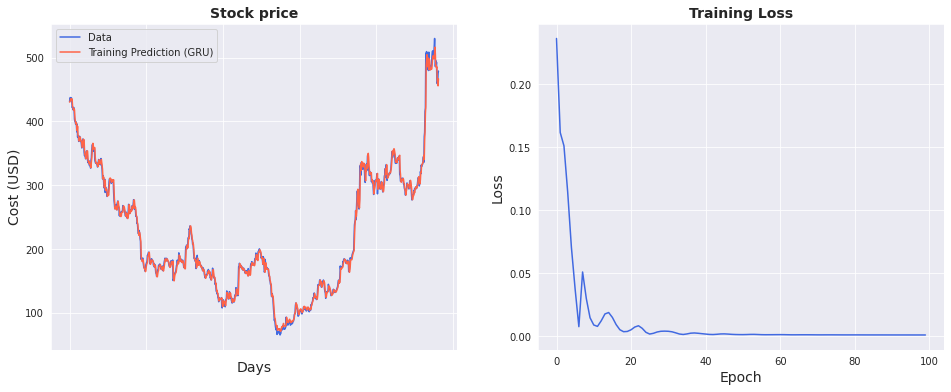

In [532]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [533]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 7.54 RMSE
Test Score: 10.62 RMSE


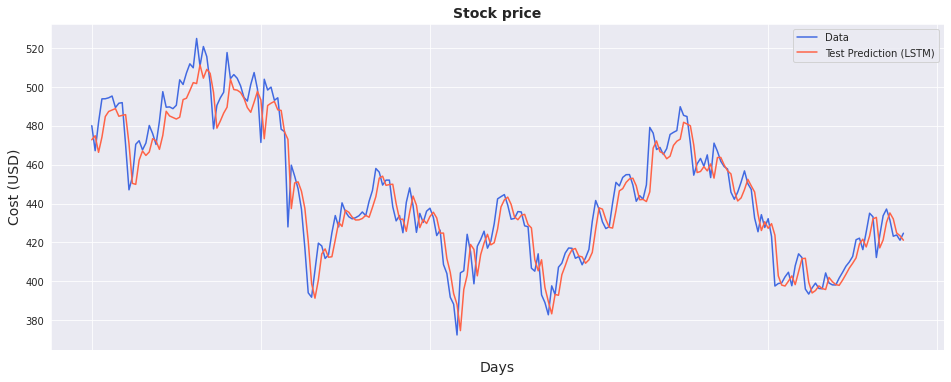

In [534]:
original = pd.DataFrame(y_test)
predict = pd.DataFrame(y_test_pred)
fig = plt.figure()

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Test Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('test_prediction.jpg')
plt.show()

In [535]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,10.409619,7.539413
Test RMSE,12.992855,10.624554
Train Time,18.870835,13.526003
